In [1]:
import os 
import glob 
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import h5py
import pickle
import pandas as pd

from math import log10, sqrt
from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

## Grab some previous data...

In [2]:
good_frames = []

with open('good_frames.txt','r') as good_frames_file:
    for frame in good_frames_file:
        good_frames.append(frame.replace('\n',''))

parts = set()

video_dict = {}

for frame in good_frames:
    if ('fakes_low_quality' in frame):
        continue
    folder_base_name = os.path.dirname(frame)
    hdf5_base_name = os.path.basename(frame).split('_')[0] + '.h5'
    hdf5_key = os.path.join(folder_base_name, hdf5_base_name)
    
    current_frames = video_dict.get(hdf5_key,[])
    video_dict[hdf5_key] = current_frames
    current_frames.append(frame)
    

In [3]:
# Load from file
svm_linear = "svm_model_linear.pkl"
svm_rbf =  "svm_model_rbf.pkl"
svm_sig =  "svm_model_sig.pkl"

training_filename = "training_set.pkl"
testing_filename = "testing_set.pkl"
testing_associated_files = "testing_files.pkl"

with open(svm_linear, 'rb') as svm_linear:
    linear_svm = pickle.load(svm_linear)
    
with open(svm_rbf, 'rb') as svm_rbf:
    rbf_svm = pickle.load(svm_rbf)
    
with open(svm_sig, 'rb') as svm_sig:
    sigmoid_svm = pickle.load(svm_sig)
    
with open(testing_filename, 'rb') as testing_filename:
    testing_set = pickle.load(testing_filename)
    
with open(testing_associated_files, 'rb') as testing_associated_file:
    x_test = pickle.load(testing_associated_file)

In [4]:
testing_labels = testing_set[:,259:260].ravel()
testing_data = testing_set[:,0:259]

## Evaluate the 3 models...

In [5]:
def get_predictons(model):
    return model.predict(testing_data) 

def evaluate_model(model,threshold=.5):
    predictions = get_predictons(model) 

    indices = list([h5py.File(x,'r').get(x).shape[0] for x in x_test])

    id_listing = []

    for n,i in enumerate(indices):
        id_listing += [n for x in range(i)]

    df = pd.DataFrame(data = list(zip(id_listing, predictions,testing_labels)), columns = ["id","predictions","label"])

    average_predictions = df.groupby('id').predictions.mean().reset_index()
    deepfake_prediction = (average_predictions['predictions'] > threshold) * 1
    deepfake_predictions = deepfake_prediction.reset_index()
    deepfake_predictions.columns = ["id","deepfake"]
    new_df = pd.merge(df, deepfake_predictions, on = 'id')
    by_video = new_df.groupby('id').max()
    
    video_confusion = confusion_matrix(by_video['label'], by_video['deepfake'])
    
    print("Video level confusion table:")
    print(video_confusion)
    
    frame_confusion = confusion_matrix(testing_labels, predictions)
    
    print("Frame level confusion table:")
    print(frame_confusion)
    
    TP = video_confusion[1,1]
    TN = video_confusion[0,0]
    FN = video_confusion[1,0]
    FP = video_confusion[0,1]
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    ACC = (TP + TN) / (TN + TP + FP + FN)
    
    fpr, tpr, thresholds = roc_curve(by_video['label'],average_predictions['predictions'])
    roc_auc = auc(fpr, tpr)
    
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    
    print("True Positive rate: {}%".format(TPR * 100))
    print("False Positive rate: {}%".format(FPR * 100))
    print("False Negative rate: {}%".format(FNR * 100))
    print("Equal Error Rate is: {}%".format(eer * 100))
    print("accuracy: {}%".format(ACC * 100))
    
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC Curve  (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return 0


Video level confusion table:
[[64  0]
 [ 0 64]]
Frame level confusion table:
[[6573    0]
 [   0 6579]]
True Positive rate: 100.0%
False Positive rate: 0.0%
False Negative rate: 0.0%
Equal Error Rate is: 0.0%
accuracy: 100.0%


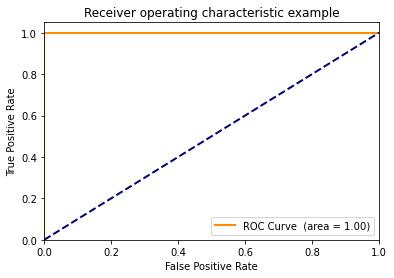

0

In [6]:
evaluate_model(linear_svm)

Video level confusion table:
[[64  0]
 [ 0 64]]
Frame level confusion table:
[[6573    0]
 [   0 6579]]
True Positive rate: 100.0%
False Positive rate: 0.0%
False Negative rate: 0.0%
Equal Error Rate is: 0.0%
accuracy: 100.0%


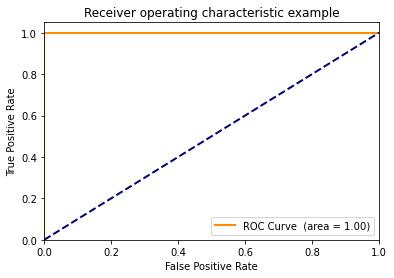

0

In [7]:
evaluate_model(rbf_svm)

Video level confusion table:
[[54 10]
 [14 50]]
Frame level confusion table:
[[5583  990]
 [1124 5455]]
True Positive rate: 78.125%
False Positive rate: 15.625%
False Negative rate: 21.875%
Equal Error Rate is: 15.17857142857143%
accuracy: 81.25%


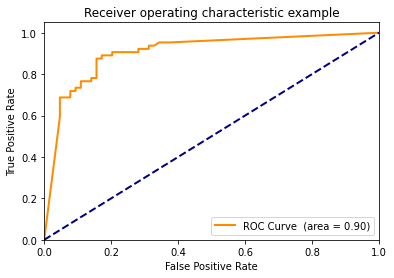

0

In [8]:
evaluate_model(sigmoid_svm)

## Done with test results...